# Decision Tree Classifier Coding Implementation

In this homework, you need to fill the TODOs in the provided DecisionTree code. 

We have provided with you the code for loading the dataset, splitting it into training and testing sets, and evaluating the model. After you implemented the correct Decision Tree Classifier, you can run the code to check the accuracy and also visualize the decision tree.

The final accuracy should be around **97%**, when decision tree max depth is set to **3**.

For submission, you need to submit the completed ipynb file and also put the visualized decision tree in the homework pdf file.

In [ ]:
import math
from collections import Counter

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


# Node class representing each node in the tree
class Node:
    def __init__(
        self, feature_index=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature_index = feature_index  # index of the feature to split on
        self.threshold = threshold  # threshold value for the split
        self.left = left  # left child node
        self.right = right  # right child node
        self.value = value  # class label if leaf node

    def is_leaf_node(self):  # check if the node is a leaf node
        return self.value is not None


# Decision Tree Classifier using Entropy
class DecisionTree:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # This function builds the decision tree, it returns a Node object for current node.
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping criteria
        if depth >= self.max_depth or num_labels == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        #Find best feature and threshold
        best_feat, best_thresh = self._best_split(X, y, num_features)

        if best_feat is None:
            # DONE: No further split is possible
            # Implement the logic to handle this case
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # DONE: Split dataset according to the searched feature and threshold
        # Implement the definition of left_idx and right_idx
        left_idx = X[:, best_feat] <= best_thresh
        right_idx = X[:, best_feat] > best_thresh
        
        #Check for empty splits
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # DONE: Grow left and right subtrees
        # Implement the logic to grow subtree, hint - use recursion to call self._grow_tree
        left = self._grow_tree(X[left_idx], y[left_idx], depth+1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth+1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in range(num_features):
            # Find the feature and corresponding threshold that achieves max information_gain
            # Implement the logic to find the best feature and threshold, hint - use self._information_gain
            feature_values = X[:, feat_idx] #Extract target feature
            thresholds = np.unique(feature_values) #Find all unique values to use as thresholds

            for threshold in thresholds:
                gain = self._information_gain(y, feature_values, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, feature_values, threshold):
        left_mask = feature_values < threshold
        right_mask = feature_values >= threshold

        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            return 0

        #Define entropy
        def entropy(labels):
            probabilities = np.bincount(labels) / len(labels)
            return -sum(p*np.log2(p) for p in probabilities if p>0)

        information_gain = None
        # Compute information gain with entropy function
        # Implement the logic to compute information gain,
        # Hint: Information Gain = Parent Entropy − Weighted Child Entropy
        H_parent = entropy(y)
        L, R = y[left_mask], y[right_mask]
        w_child = (len(L)/len(y))*entropy(L) + (len(R)/len(y))*entropy(R)
        information_gain = H_parent - w_child

        return information_gain

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        # DONE: Traverse left or right
        # Implement the logic to traverse the tree, hint - use recursion to call self._traverse_tree
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [2]:
# === Run the Decision Tree on Iris dataset ===
# You should not modify following code.
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Custom Decision Tree (Entropy) Accuracy: {accuracy:.2f}")

Custom Decision Tree (Entropy) Accuracy: 1.00


In [3]:
def plot_decision_tree(
    node, feature_names, depth=0, pos=(0.5, 1.0), x_offset=0.25, y_offset=0.1, ax=None
):
    import matplotlib.pyplot as plt

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_axis_off()

    # Create label
    if node.is_leaf_node():
        label = f"Leaf\nClass: {node.value}"
    else:
        feature_name = feature_names[node.feature_index]
        label = f"{feature_name} < {node.threshold:.2f}"

    # Draw current node
    ax.text(
        pos[0],
        pos[1],
        label,
        ha="center",
        va="center",
        bbox=dict(boxstyle="round", facecolor="lightblue"),
    )

    # Draw child nodes and connections
    if not node.is_leaf_node():
        left_pos = (pos[0] - x_offset, pos[1] - y_offset)
        right_pos = (pos[0] + x_offset, pos[1] - y_offset)

        ax.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], "k-")
        ax.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], "k-")

        plot_decision_tree(
            node.left, feature_names, depth + 1, left_pos, x_offset * 0.6, y_offset, ax
        )
        plot_decision_tree(
            node.right,
            feature_names,
            depth + 1,
            right_pos,
            x_offset * 0.6,
            y_offset,
            ax,
        )

    if depth == 0:
        plt.show()


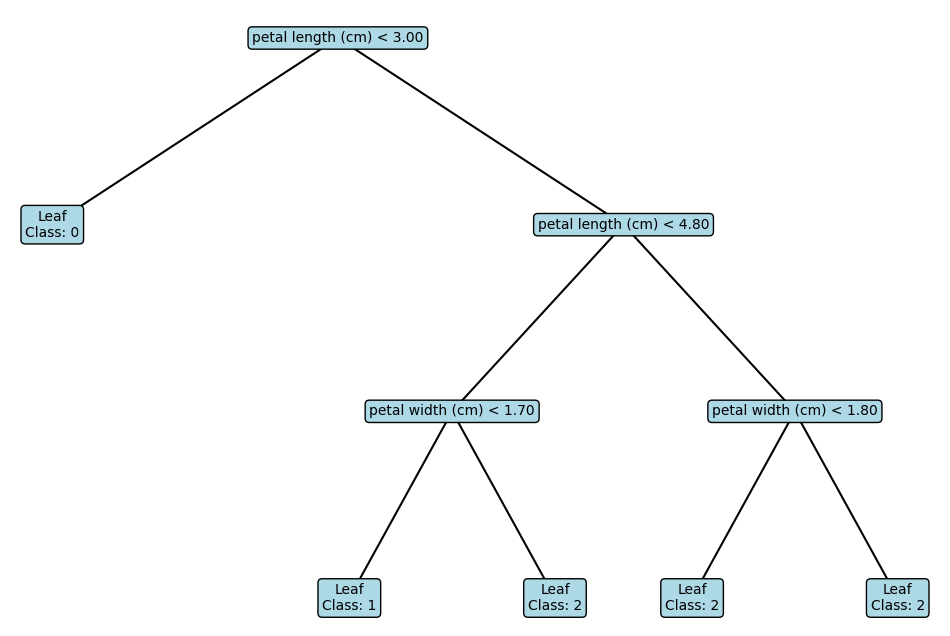

In [4]:
# Visualize the tree with feature names
# You should not modify following code.
plot_decision_tree(clf.root, feature_names=iris.feature_names)